## Monre Carlo Learning 和 Sarsa Learning ：
1. - MC Learning 是基于完整回合（episode）的。是在episode上从后往前更新相关state-action pair的return value G的，再根据G使用RM算法更新action value Q
   - Sarsa Learning 是基于一步时序差分（TD）， 每一步交互后即可使用RM算法更新action value Q，减少TD误差，最终使Q ≈ TD目标
2. - 更新目标：MC用实际回报 𝐺𝑡。Sarsa用TD目标 r+γQ(s′,a′) 来更新
3. - 两种算法都不需要模型参数（model-free）
4. - MC无偏（unbiased）， Sarsa有偏（biased）但方差更小
5. - 收敛速度: MC慢（需要整回合）Sarsa快（逐步逼近）

## Sarsa Learning 算法过程：
1. - 初始化： 设定学习率 α、折扣因子 γ、探索率 ε、最大回合数episodes。对所有state-action pair的action value初始化 Q(s,a)=0。
2. - 开始每个回合（episode）：
      - 初始state s = start state
      - 初始action：用ε-greedy，在Q(s,a)中，大概率最优action，小概率其他action
      - 更新Q： 
         - ![Sarsa Learning.png](<attachment:Sarsa Learning.png>)
      - 前进：s' ← s  a' ← a
      - 直到s = goal state 或者 step > max_step
   - 所有episode结束，通过Q求得state values 和 policy

### 我对Gird world进行了修改，添加了出发点start state，以后算法的目标是获得一个路径，从start state到goal state。 而以前的算法是求任意state都能达到goal state的全局策略。
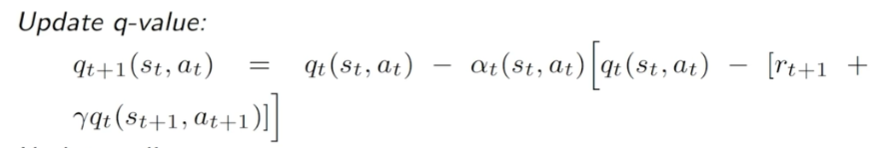

In [102]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(20)

class GridWorld:
    def __init__(self, rows=7, cols=7, goal=(5,5), reward= -1, start=(0,0), forbidden=[(1,4),(2,3),(2,2),(3,3),(4,5),(5,4),(5,6)]):
        self.rows = rows
        self.cols = cols
        self.start = start
        self.goal = goal
        self.reward = reward
        self.forbidden = set(forbidden)
        self.actions = {
            0: (-1, 0),  # up
            1: (0, 1),   # right
            2: (1, 0),   # down
            3: (0, -1),   # left
            4: (0, 0)    # stay
        }

        self.left_map = {0:3, 1:0, 2:1, 3:2, 4:4}   # 左转90°
        self.right_map = {0:1, 1:2, 2:3, 3:0, 4:4}  # 右转90°

    def step(self, state, action):
        """输入 state=(r,c), action，返回 (next_state, reward)"""
        r, c = state

        # 随机转移
        if action == 4:
            dr, dc = self.actions[action]
        else:
            prob = np.random.rand()
            if prob < 0.1:   # 左偏
                action = self.left_map[action]
            elif prob < 0.2: # 右偏
                action = self.right_map[action]
            # 其余 80% 保持不变
            dr, dc = self.actions[action]

        new_r, new_c = r + dr, c + dc

        # 撞墙，移动惩罚，额外惩罚10点
        if not (0 <= new_r < self.rows and 0 <= new_c < self.cols):
            return state, -5 + self.reward

        # 禁区，额外移动惩罚，额外惩罚10点
        if (new_r, new_c) in self.forbidden:
            return (new_r, new_c), -10 + self.reward

        # 到达目标，移动惩罚，额外奖励10点
        if (new_r, new_c) == self.goal:
            return (new_r, new_c), 10 + self.reward

        # 普通移动惩罚
        return (new_r, new_c), 0 + self.reward
    
    def get_states(self):
        """返回所有可用状态"""
        states = []
        for r in range(self.rows):
            for c in range(self.cols):
                states.append((r, c))
        return states
    
    
    def render(self, policy=None, values=None, cell_size=1.2, show_path=True):
        """可视化：白色=正常, 黄=禁区, 蓝=goal, 灰=起点, 红线=路径"""
        fig, ax = plt.subplots(figsize=(self.cols * cell_size, self.rows * cell_size))

        # ---- 绘制格子背景 ----
        grid = np.ones((self.rows, self.cols, 3))  # 默认白色
        for (r, c) in self.forbidden:
            grid[r, c] = [1, 1, 0]  # 黄色
        gr, gc = self.goal
        grid[gr, gc] = [0, 0, 1]  # 蓝色
        sr, sc = self.start
        grid[sr, sc] = [0.5, 0.5, 0.5]  # 灰色表示起点

        ax.imshow(grid, origin="upper")

        # ---- 显示值函数 ----
        if values is not None:
            for (r, c), v in values.items():
                ax.text(c, r + 0.25, f"{v:.1f}", ha='center', va='top', color='black', fontsize=12)

        # ---- 显示策略箭头 ----
        if policy is not None:
            arrows = {0: "↑", 1: "→", 2: "↓", 3: "←", 4: "O"}
            for (r, c), a in policy.items():
                ax.text(c, r - 0.2, arrows[a], ha='center', va='center', color='red', fontsize=16, fontweight='bold')

        # ---- 绘制路径（按策略从 start -> goal） ----
        if policy is not None and show_path:
            path = [self.start]
            state = self.start
            visited = set()
            for _ in range(1000):  # 防止死循环
                if state == self.goal:
                    break
                if state in visited:
                    break
                visited.add(state)
                action = policy.get(state, 4)
                dr, dc = self.actions[action]
                next_state = (state[0] + dr, state[1] + dc)
                if next_state not in self.get_states():  # 越界
                    break
                path.append(next_state)
                state = next_state

            # 绘制红线路径（注意行列转为 x,y）
            xs = [c for r, c in path]
            ys = [r for r, c in path]
            ax.plot(xs, ys, color='red', linewidth=2, marker='o', markersize=6, alpha=0.8)

        # ---- 网格与样式 ----
        ax.set_xticks(np.arange(-0.5, self.cols, 1))
        ax.set_yticks(np.arange(-0.5, self.rows, 1))
        ax.grid(which="both", color="black", linewidth=1)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.show()


In [103]:
def epsilon_greedy(Q, state, actions, eps=0.1):
    """epsilon-greedy策略"""
    best_action = max(actions.keys(), key=lambda a: Q[(state, a)])  
    if np.random.rand() < eps:
        return np.random.choice(list(actions.keys()))  # 随机探索
    else:
        return best_action  # 利用

In [104]:
def Sarsa_Learning(env, episodes=500, alpha=0.1, gamma=0.9, eps=0.1):
    """Sarsa算法"""
    Q = {} # Q值字典，键为(state, action)，值为Q值
    Total_rewards = []  # 每个episode总奖励
    Episode_lengths = []  # 每个episode的长度

    # 初始化 Q值字典
    for state in env.get_states():
        for action in env.actions.keys():
            Q[(state, action)] = 0.0
    
    # 开始训练
    for ep in range(episodes):
        state = env.start # 从起点开始
        action = epsilon_greedy(Q, state, env.actions, eps) # 初始动作用行为策略采样（on-policy）
        total_reward = 0 # 该episode总奖励
        step = 0 # 该episode步数

        while state != env.goal:
            next_state, next_reward = env.step(state, action) 
            next_action = epsilon_greedy(Q, next_state, env.actions, eps)

            # update Q value
            # Q[(state, action)] = Q[(state, action)] - alpha * (Q[(state, action)] - (next_reward + gamma * Q[(next_state, next_action)]))
            Q[(state, action)] += alpha * (next_reward + gamma * Q[(next_state, next_action)] - Q[(state, action)])

            # move to next state
            state = next_state
            action = next_action

            # 记录数据
            total_reward += next_reward
            step += 1

            # 防止死循环
            if step > 1000: 
                break
    
        # 储存数据
        Total_rewards.append(total_reward)
        Episode_lengths.append(step)

    # 训练结束后，构建最终的 policy 与 values 供渲染/评估 (因为训练中的policy是带有greedy成分的，不是最终policy)
    final_policy = {}
    values = {}
    for s in env.get_states():
        best_a = max(env.actions.keys(), key=lambda a: Q[(s, a)])
        final_policy[s] = best_a
        values[s] = max(Q[(s, a)] for a in env.actions.keys())


    return values, final_policy, Total_rewards, Episode_lengths

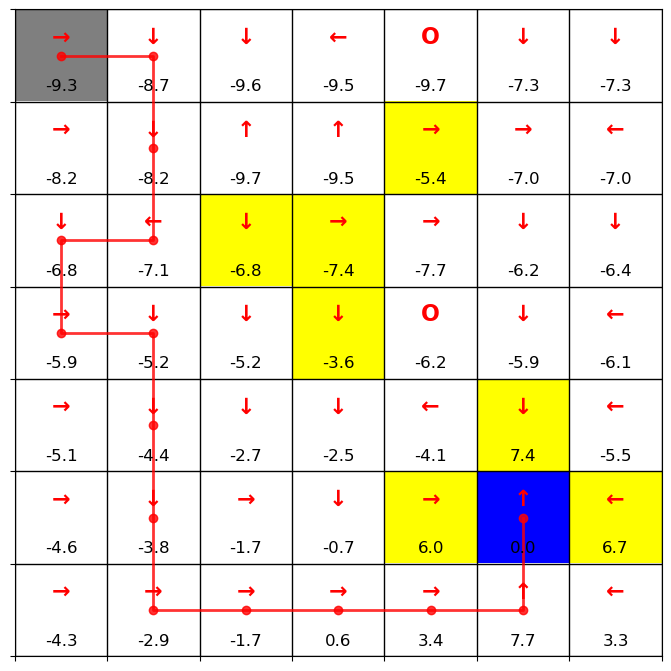

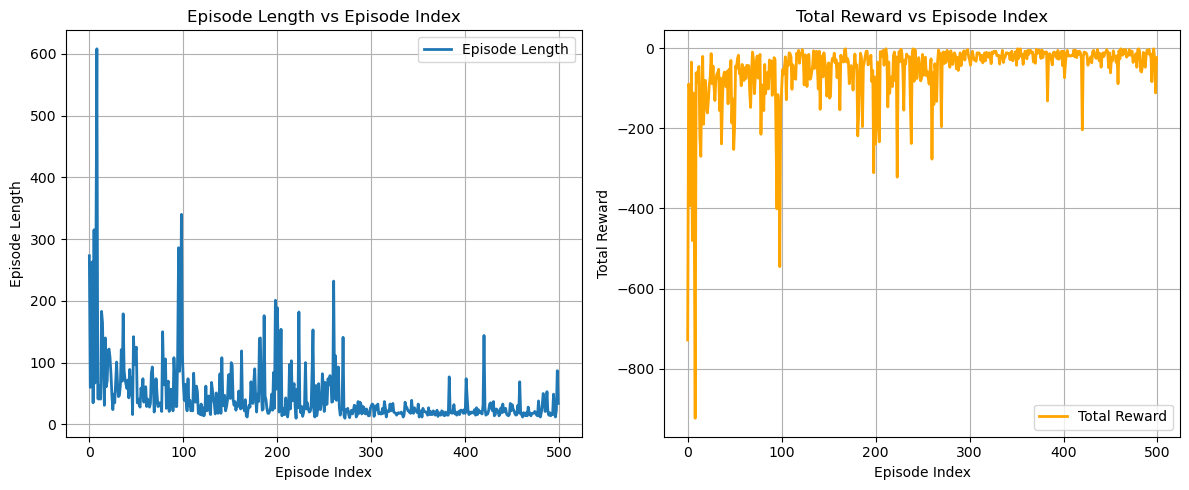

In [105]:
# 运行
env = GridWorld()

# 开始训练
values, policy, Total_rewards, Episode_lengths = Sarsa_Learning(env, episodes=500, alpha=0.1, gamma=0.9, eps=0.1)
env.render(policy, values)

# 画出效果图
plt.figure(figsize=(12, 5))
episodes = list(range(len(Episode_lengths)))
# ---- 图1：Episode Length ----
plt.subplot(1, 2, 1)
plt.plot(episodes, Episode_lengths, label='Episode Length', linewidth=2)
plt.xlabel('Episode Index')
plt.ylabel('Episode Length')
plt.title('Episode Length vs Episode Index')
plt.grid(True)
plt.legend()

# ---- 图2：Total Reward ----
plt.subplot(1, 2, 2)
plt.plot(episodes, Total_rewards, color='orange', label='Total Reward', linewidth=2)
plt.xlabel('Episode Index')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode Index')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()